### Instalación de librerias e imports

In [ ]:
!pip install igraph
!pip install cairocffi
!pip install scikit-network

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.1 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=8cf8b136388a8a7d96d90a0111e744dc59096b42a394242b5d9b78500620a2da
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 8.1 MB 4.2 MB/s 


In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.decomposition import PCA
import numpy as np
from numpy import vstack
from numpy import zeros
from numpy.random import rand
from numpy.linalg import norm
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import radius_neighbors_graph
from statistics import stdev
import scipy.sparse
import igraph
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.topology import get_connected_components, get_largest_connected_component
from sknetwork.visualization import svg_graph, svg_bigraph

In [ ]:
# Necesario para ver entre las capas
disable_eager_execution()

### Función para sacar los outputs de la capas


In [ ]:
def get_layers_output(model, data):

  inp = model.input                                           
  outputs = [layer.output for layer in model.layers]          
  functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs] 

  layer_outs = [func([x, 1.]) for func in functors]
  return layer_outs

### Ejemplo para pintar grafos comentado

In [ ]:
#labels = get_connected_components(matriz_grafo)
#image = svg_graph(matriz_grafo, labels=labels)
#new_adjacency, index = get_largest_connected_component(matriz_grafo, return_index=True)
#labels = get_connected_components(matriz_grafo)
#image = svg_graph(new_adjacency, labels=index)
#new_adjacency
#index
#SVG(image)
#new_adjacency
#len(index)

## Funciones para sacar los coeficientes de enredo.

In [ ]:
def get_grafo_knn(datos,ratio_min):
  k = 1
  matriz_grafo = kneighbors_graph(np.array(datos), k, mode='distance')
  matriz_grafo = matriz_grafo.todense()
  matriz_grafo = np.array(matriz_grafo)

  for i in range(len(matriz_grafo)):
    for j in range(len(matriz_grafo)):
      matriz_grafo[j][i]=matriz_grafo[i][j]
  try:
    new_adjacency, index = get_largest_connected_component(matriz_grafo, return_index=True)
    ratio_connected = len(index)/len(datos)
  except:
    ratio_connected = 0
  if ratio_connected>ratio_min:
    matriz_grafo = new_adjacency.todense()
    g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')
    print('Número de instancias:',len(index))
    print('número de vecinos:',k)
    return g
  g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')
  while not g.is_connected():
    
    matriz_grafo = kneighbors_graph(datos, k, mode='distance')
    matriz_grafo = matriz_grafo.todense()
    matriz_grafo = np.array(matriz_grafo)
    
    for i in range(len(matriz_grafo)):
      for j in range(len(matriz_grafo)):
        matriz_grafo[j][i]=matriz_grafo[i][j]
    try:
      new_adjacency, index = get_largest_connected_component(matriz_grafo, return_index=True)
      ratio_connected = len(index)/len(datos)
    except:
      ratio_connected = 0
    if ratio_connected>ratio_min:
      matriz_grafo = new_adjacency.todense()
      g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')
      print('Número de instancias:',len(index))
      print('número de vecinos:',k)
      return g
    g = igraph.Graph.Weighted_Adjacency(matriz_grafo,mode ='undirected')
    k +=1
  print('número de vecinos:', k)
  return g

In [ ]:
# Radio para que sea conectado
def radio_minimo(datos, incremento=0.01):
  n_puntos = datos.shape[0]
  G_E = distancia_euclidea(datos)
  maximo_GE = np.amax(G_E)
  diagonal_grande = np.diag(np.zeros((n_puntos,)) + maximo_GE)
  radio = np.amax(np.amin(G_E + diagonal_grande, axis=0))
  radio = radio + incremento
  return radio

In [ ]:
def get_grafo_rnn(datos,ratio_min):
  radius = 0.01
  n_puntos = datos.shape[0]
  matriz_grafo = radius_neighbors_graph(np.array(datos), radius, mode='distance')
  matriz_grafo = matriz_grafo.todense()
  g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')

  while not g.is_connected():
    n_puntos = datos.shape[0]
    matriz_grafo = radius_neighbors_graph(datos, radius, mode='distance')
    try:
      new_adjacency, index = get_largest_connected_component(matriz_grafo, return_index=True)
      ratio_connected = len(index)/len(datos)
    except:
      ratio_connected = 0
    if ratio_connected>ratio_min:
      matriz_grafo = new_adjacency.todense()
      g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')
      print('Número de instancias:',len(index))
      print('radio:',radius)
      return g
    matriz_grafo = matriz_grafo.todense()
    g = igraph.Graph.Weighted_Adjacency(matriz_grafo, mode='undirected')

    radius += 0.01  
  print('radio:',radius)
  return g

In [ ]:
def distancia_euclidea(datos, dim):
  #n_puntos = datos.shape[0]
  G_E = zeros((dim, dim))
  for i in range(dim):
    for j in range(dim):
      G_E[i, j] = norm(datos[i]-datos[j])
  return G_E

In [ ]:
def distancia_geodesica(datos,ratio_min,tipo):
  #radio_min = radio_minimo(datos)

  grafo = get_grafo_rnn(datos,ratio_min) if tipo == 'r' else get_grafo_knn(datos,ratio_min)
  caminos = grafo.distances(weights='weight')
  caminos = np.asarray(caminos)
  return caminos, len(caminos)

In [ ]:
def vector_triu(matriz):
  n = matriz.shape[0]
  i, j = np.triu_indices(n-1)
  return matriz[i, j+1]

In [ ]:
def coef_entangle(datos,ratio_min,tipo):
# g es el grafo correspondiente a datos
  G_M, dim = distancia_geodesica(datos,ratio_min,tipo)
  G_E = distancia_euclidea(datos, dim)
  r_E = vector_triu(G_E)
  r_M = vector_triu(G_M)
  c = np.mean(1-np.multiply(r_M - np.mean(r_M), r_E - np.mean(r_E)) / (stdev(r_E)*stdev(r_M)))
  d = np.mean(np.divide(np.abs(r_M - r_E), r_E))  
  return c, d

In [ ]:
def remove_outliers(layer):
  mu = [np.mean(l) for l in layer.transpose()]
  dev =  [np.std(l) for l in layer.transpose()]
  layer = np.array([point for point in layer if norm(point-mu)<norm(dev)])
  print('número de datos:',len(layer))
  return layer

In [ ]:
def do_report(x,layer_outputs,mask_0,mask_1,max_capas,ratio_min,tipo):
  input_0 = np.array(x.iloc[mask_0])
  input_1 = np.array(x.iloc[mask_1])
  print(f'------------ Input ------------')
  print('Variedad_0: c, d',coef_entangle(input_0,ratio_min,tipo))
  print('Variedad_1: c, d',coef_entangle(input_1,ratio_min,tipo))

  for id, layer_out in enumerate(layer_outputs[:max_capas]):
    l = list(map(list, zip(*layer_out)))
    layer_data = np.array([row[0] for row in l])
    layer_out_0 = layer_data[mask_0]
    layer_out_1 = layer_data[mask_1]
    print(f'------------CAPA {id+1}------------')
    print('Variedad_0: c, d:',coef_entangle(layer_out_0,ratio_min,tipo))
    print('Variedad_1: c, d',coef_entangle(layer_out_1,ratio_min,tipo))
  return None


In [ ]:
def do_report_table(x,layer_outputs,mask_0,mask_1,max_capas=4,ratio_min=0.6,tipo ='r'):
  input_0 = np.array(x.iloc[mask_0])
  input_1 = np.array(x.iloc[mask_1])
  df = pd.DataFrame(
   columns =['c - Clase 8', 'd-Clase 8', 'c-Clase 1', 'd-Clase 1']
)
  
  c_0,d_0 = coef_entangle(input_0,ratio_min,tipo)
  c_1,d_1 = coef_entangle(input_1,ratio_min,tipo)

  df.loc['Entrada'] = [c_0,d_0,c_1,d_1]


  for id, layer_out in enumerate(layer_outputs[:max_capas]):
    print(f'------------CAPA {id+1}------------')
    l = list(map(list, zip(*layer_out)))
    layer_data = np.array([row[0] for row in l])
    layer_out_1 = layer_data[mask_1]
    layer_out_0 = layer_data[mask_0]
    c_0,d_0 = coef_entangle(layer_out_0,ratio_min,tipo)
    c_1,d_1 = coef_entangle(layer_out_1,ratio_min,tipo)
    df.loc[f'Capa {id+1}'] = [c_0,d_0,c_1,d_1]
  return df

In [ ]:
df = pd.DataFrame(
    {
    'Medida de enredo' : ['c','d','c','d']}
)
df = df.transpose()
#df.columns= df.loc['Clase']
df.columns =['Clase 1', 'Clase 1', 'Clase 0', 'Clase 0']


# EJEMPLOS

## DATASET ESPIRAL

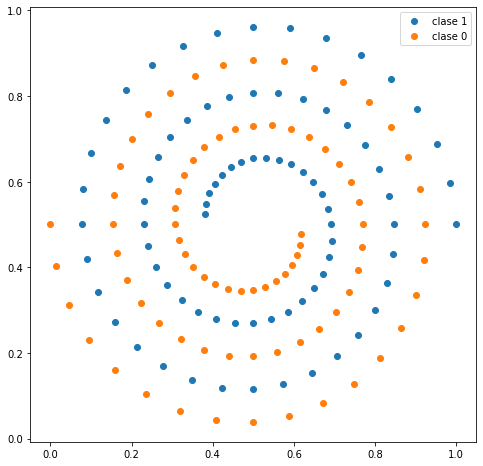

In [ ]:
def spiral_xy(i, spiral_num, freq):
    """
    Create the data for a spiral.
    """
    φ = math.pi*i/(freq*16)  
    r = 6.5 * ((freq*104 - i)/(freq*104))
    x = (r * math.cos(φ) * spiral_num)/13 + 0.5
    y = (r * math.sin(φ) * spiral_num)/13 + 0.5
    return (x, y)

def spiral(spiral_num):
    return [spiral_xy(i,spiral_num,1) for i in range(80)]


a_x = list(zip(*spiral(1)))[0]
a_y = list(zip(*spiral(1)))[1]

b_x = list(zip(*spiral(-1)))[0]
b_y = list(zip(*spiral(-1)))[1]

plt.figure(figsize=(8, 8))

plt.scatter(a_x,a_y, label = 'clase 1')
plt.scatter(b_x,b_y,  label = 'clase 0')
plt.legend()
plt.show()

In [ ]:
data_class_1 = [[x,y,1] for x,y in spiral(1)]
data_class_0 = [[x,y,0] for x,y in spiral(-1)]
data = data_class_1+data_class_0
data_df =pd.DataFrame(data)
data_df = data_df.sample(frac=1).reset_index(drop=True)
x, y  = data_df.iloc[:,:-1],data_df.iloc[:,-1]


### Entrenamiento de la red neuronal

In [ ]:

# Fijamos la semilla para que no varie nuestro modelo de un entranamiento a otro
tf.random.set_seed(0)
optimizer = keras.optimizers.Adam(learning_rate=0.0015)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
model = keras.Sequential([

    layers.Dense(units=20, activation='relu', input_shape=[2]),
    layers.Dense(units=20, activation='relu'),
    layers.Dense(units=15, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=5, activation='relu'),
    layers.Dense(units=5, activation='relu'),


    layers.Dense(units=1,activation = 'sigmoid'),
])
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'],experimental_run_tf_function=False)

history = model.fit(
    x,y ,
    batch_size=30,
    epochs=1250,
    callbacks = [es],
    verbose=1, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)

Train on 160 samples
Epoch 1/1250
160/160 [==============================] - 0s 2ms/sample - loss: 0.6929 - accuracy: 0.5437
Epoch 2/1250
160/160 [==============================] - 0s 121us/sample - loss: 0.6926 - accuracy: 0.5000
Epoch 3/1250
160/160 [==============================] - 0s 110us/sample - loss: 0.6919 - accuracy: 0.5437
Epoch 4/1250
160/160 [==============================] - 0s 114us/sample - loss: 0.6917 - accuracy: 0.5500
Epoch 5/1250
160/160 [==============================] - 0s 129us/sample - loss: 0.6910 - accuracy: 0.5562
Epoch 6/1250
160/160 [==============================] - 0s 107us/sample - loss: 0.6903 - accuracy: 0.5437
Epoch 7/1250
160/160 [==============================] - 0s 121us/sample - loss: 0.6908 - accuracy: 0.5437
Epoch 8/1250
160/160 [==============================] - 0s 117us/sample - loss: 0.6887 - accuracy: 0.5562
Epoch 9/1250
160/160 [==============================] - 0s 127us/sample - loss: 0.6905 - accuracy: 0.5312
Epoch 10/1250
160/160 [====

KeyboardInterrupt: ignored

In [ ]:
accuracy = model.evaluate(x, y)[1]
layers_numbers = len(model.layers)
model_path = f'{layers_numbers}_layers_{accuracy:.2f}_accuracy.h5'
model_path

In [ ]:
#model.save(model_path)

In [ ]:
model.evaluate(x, y)[1]

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/TFM Zumaquero (MAT)/9_layers_1.00_accuracy.h5')


In [ ]:
layer_outputs = get_layers_output(model, x)
mask_spiral_1 = [i==1 for i in y]
mask_spiral_0 = [i==0 for i in y]

### Reporte de las medidas de enredo aplicando el método del radio para el grafo de vecino próximo

In [ ]:
do_report(x,layer_outputs,mask_spiral_0,mask_spiral_1,0.85,'r')


TypeError: ignored

In [ ]:
print(do_report_table(x,layer_outputs,mask_spiral_0,mask_spiral_1,ratio_min = 0.85, max_capas=9,tipo = 'k').to_latex())


Número de instancias: 80
número de vecinos: 2
Número de instancias: 80
número de vecinos: 2
------------CAPA 1------------
Número de instancias: 80
número de vecinos: 2
Número de instancias: 80
número de vecinos: 2
------------CAPA 2------------
Número de instancias: 80
número de vecinos: 3
Número de instancias: 80
número de vecinos: 3
------------CAPA 3------------
Número de instancias: 71
número de vecinos: 3
Número de instancias: 80
número de vecinos: 3
------------CAPA 4------------
Número de instancias: 71
número de vecinos: 4
Número de instancias: 80
número de vecinos: 8
------------CAPA 5------------
Número de instancias: 69
número de vecinos: 7
Número de instancias: 80
número de vecinos: 12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


------------CAPA 6------------
Número de instancias: 69
número de vecinos: 6
Número de instancias: 80
número de vecinos: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


------------CAPA 7------------
Número de instancias: 69
número de vecinos: 5
Número de instancias: 80
número de vecinos: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


------------CAPA 8------------
Número de instancias: 69
número de vecinos: 4
Número de instancias: 79
número de vecinos: 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


------------CAPA 9------------
Número de instancias: 80
número de vecinos: 9
Número de instancias: 79
número de vecinos: 8
\begin{tabular}{lrrrr}
\toprule
{} &  c - Clase 0 &  d-Clase 0 &  c-Clase 1 &  d-Clase 1 \\
\midrule
Entrada &     0.774671 &   2.600329 &   0.747079 &   3.338851 \\
Capa 1  &     0.734755 &   2.675865 &   0.713226 &   3.471020 \\
Capa 2  &     0.618481 &   2.635013 &   0.665317 &   1.993438 \\
Capa 3  &     1.019668 &   1.840620 &   0.324711 &   1.823325 \\
Capa 4  &     0.974680 &   1.757115 &   0.404784 &   1.494007 \\
Capa 5  &     1.082427 &        inf &   0.195873 &   0.756577 \\
Capa 6  &     1.082466 &        inf &   0.145775 &   0.766150 \\
Capa 7  &     1.010973 &        inf &   0.025869 &   0.223875 \\
Capa 8  &     1.009014 &        inf &   0.022096 &   0.249882 \\
Capa 9  &     0.000322 &        NaN &   0.148876 &        inf \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


###Reporte de las medidas de enredo aplicando k vecimos más próximos

In [ ]:
do_report(x,layer_outputs,mask_spiral_1,mask_spiral_0,0.9,'k')

------------ Input ------------
Número de instancias: 80
número de vecinos: 2
Variedad_0: c, d (0.7746668737834463, 2.600304477706908)
Número de instancias: 80
número de vecinos: 2
Variedad_1: c, d (0.7746668737834463, 2.600304477706908)
------------CAPA 1------------
Número de instancias: 80
número de vecinos: 2
Variedad_0: c, d: (0.7449607703767789, 2.6500236194120648)
Número de instancias: 80
número de vecinos: 2
Variedad_1: c, d (0.7347487734324195, 2.675825513286094)
------------CAPA 2------------
Número de instancias: 78
número de vecinos: 2
Variedad_0: c, d: (0.8805227836661025, 4.743862905456993)
Número de instancias: 80
número de vecinos: 3
Variedad_1: c, d (0.6377476490434313, 2.2511114200159335)
------------CAPA 3------------
Número de instancias: 80
número de vecinos: 3
Variedad_0: c, d: (0.29304689125776173, 2.0091903001576252)
Número de instancias: 80
número de vecinos: 6
Variedad_1: c, d (0.09025735797582556, 0.7006310941471202)
------------CAPA 4------------
Número de i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Variedad_1: c, d (0.9493429512319218, inf)
------------CAPA 6------------
Número de instancias: 80
número de vecinos: 6
Variedad_0: c, d: (0.1435279860588225, 0.6844298675029441)
Número de instancias: 80
número de vecinos: 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Variedad_1: c, d (0.0023055614521473337, inf)
------------CAPA 7------------
Número de instancias: 80
número de vecinos: 7
Variedad_0: c, d: (0.010705892263715239, 0.1938056889843944)
Número de instancias: 79
número de vecinos: 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Variedad_1: c, d (0.05760890301824602, inf)
------------CAPA 8------------
Número de instancias: 80
número de vecinos: 8
Variedad_0: c, d: (0.016553871537798047, 0.20422385714082222)
Número de instancias: 80
número de vecinos: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Variedad_1: c, d (0.0003985693470025497, inf)
------------CAPA 9------------
Número de instancias: 76
número de vecinos: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Variedad_0: c, d: (0.7759963206542018, inf)
Número de instancias: 80
número de vecinos: 6
Variedad_1: c, d (0.00032163311633701846, nan)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## DATASET DIGITOS

In [ ]:
from sklearn.datasets import load_digits
#from keras.datasets import mnist
import pandas as pd

digits=load_digits(as_frame=True)
mnist.load_data()
X = digits.data
Y = digits.target
X['target'] = Y

X.shape

(1797, 65)

In [ ]:

digits_mask = [i==8 or i==1 for i in Y]
digits_df = X.iloc[digits_mask]
digits_df['target'] = digits_df['target'].replace(8,0)
digits_df =digits_df.reset_index(drop =True)
x, y  =  digits_df.iloc[:,:-1],digits_df.iloc[:,-1]
x.shape

#x.iloc[mask_digits_1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(356, 64)

### Entrenamos dataset de digitos

In [ ]:
# Fijamos la semilla para que no varie nuestro modelo de un entranamiento a otro
tf.random.set_seed(0)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
model = keras.Sequential([

    layers.Dense(units= 10, activation='relu', input_shape=[64]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=10, activation='relu'),



    


    layers.Dense(units=1,activation = 'sigmoid'),
])
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'],experimental_run_tf_function=False)

history = model.fit(
    x,y ,
    batch_size=60,
    epochs=300,
    callbacks = [es],
    verbose=1, # hide the output because we have so many epochs
)



Train on 356 samples
Epoch 1/300
356/356 [==============================] - 0s 557us/sample - loss: 1.6305 - accuracy: 0.4888
Epoch 2/300
356/356 [==============================] - 0s 59us/sample - loss: 0.8806 - accuracy: 0.5281
Epoch 3/300
356/356 [==============================] - 0s 57us/sample - loss: 0.6145 - accuracy: 0.7303
Epoch 4/300
356/356 [==============================] - 0s 72us/sample - loss: 0.5816 - accuracy: 0.6826
Epoch 5/300
356/356 [==============================] - 0s 63us/sample - loss: 0.5514 - accuracy: 0.7022
Epoch 6/300
356/356 [==============================] - 0s 61us/sample - loss: 0.4990 - accuracy: 0.7640
Epoch 7/300
356/356 [==============================] - 0s 55us/sample - loss: 0.4559 - accuracy: 0.8287
Epoch 8/300
356/356 [==============================] - 0s 42us/sample - loss: 0.4152 - accuracy: 0.8567
Epoch 9/300
356/356 [==============================] - 0s 45us/sample - loss: 0.3742 - accuracy: 0.8596
Epoch 10/300
356/356 [====================

In [ ]:
accuracy = model.evaluate(x, y)[1]
layers_numbers = len(model.layers)
model_path = f'bueno_digits_{layers_numbers}_layers_{accuracy:.2f}_accuracy.h5'
model_path

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


'bueno_digits_4_layers_1.00_accuracy.h5'

In [ ]:
model.save(model_path)

In [ ]:
layer_outputs_digits = get_layers_output(model, x)
mask_digits_0 = [i==0 for i in y]
mask_digits_1 = [i==1 for i in y]
sum([1 for i in mask_digits_0 if i])

174

### Reporte de tipo k vecinos próximos

In [ ]:
print(do_report_table(x,layer_outputs_digits,mask_digits_0,mask_digits_1,3,0.8,'k').to_latex())

Número de instancias: 165
número de vecinos: 3
Número de instancias: 152
número de vecinos: 3
------------CAPA 1------------
Número de instancias: 166
número de vecinos: 3
Número de instancias: 165
número de vecinos: 3
------------CAPA 2------------
Número de instancias: 172
número de vecinos: 3
Número de instancias: 157
número de vecinos: 3
------------CAPA 3------------
Número de instancias: 174
número de vecinos: 4
Número de instancias: 167
número de vecinos: 3
\begin{tabular}{lrrrr}
\toprule
{} &  c - Clase 8 &  d-Clase 8 &  c-Clase 1 &  d-Clase 1 \\
\midrule
Entrada &     0.831490 &   3.187087 &   0.857910 &   2.835405 \\
Capa 1  &     0.729243 &   2.219888 &   0.957741 &   2.274444 \\
Capa 2  &     0.394193 &   2.221966 &   0.937739 &   2.476651 \\
Capa 3  &     0.099564 &   0.882331 &   0.907917 &   2.139596 \\
\bottomrule
\end{tabular}



### Reporte de tipo radio 

In [ ]:
do_report(x,layer_outputs_digits,mask_digits_0,mask_digits_1,0.7,'r')


------------ Input ------------
Número de instancias: 122
radio: 22.280000000000683
Variedad_0: c, d (0.9181403213955875, 1.6687281040205002)
Número de instancias: 145
radio: 19.420000000000236
Variedad_1: c, d (0.9181640868189949, 2.0030729092805797)
------------CAPA 1------------
Número de instancias: 122
radio: 5.199999999999934
Variedad_0: c, d: (0.9726883553609743, 0.8748769643399033)
Número de instancias: 137
radio: 6.529999999999905
Variedad_1: c, d (0.834442408324243, 1.7684780607397772)
------------CAPA 2------------
Número de instancias: 127
radio: 1.8600000000000014
Variedad_0: c, d: (0.9758343500562816, 0.7972312792610193)
Número de instancias: 130
radio: 1.9800000000000015
Variedad_1: c, d (0.9955539378880658, 1.0161563719404019)
------------CAPA 3------------
Número de instancias: 122
radio: 0.4400000000000002
Variedad_0: c, d: (1.0533673058568735, 5.131798104807698)
Número de instancias: 147
radio: 1.1100000000000008
Variedad_1: c, d (0.933142151230111, 1.203496932583114

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


### Reporte radio en formato tabla


In [ ]:
do_report_table(x,layer_outputs_digits,mask_digits_0,mask_digits_1,ratio_min = 1)


radio: 32.12000000000218
radio: 30.84000000000202
------------CAPA 1------------
radio: 15.429999999999715
radio: 11.299999999999804
------------CAPA 2------------
radio: 7.779999999999879
radio: 4.8299999999999415
------------CAPA 3------------
radio: 5.279999999999932
radio: 2.7799999999999847
------------CAPA 4------------
radio: 0.35000000000000014
radio: 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


,c - Clase 1,d-Clase 1,c-Clase 0,d-Clase 0
Entrada,0.090880,3.909119e-01,0.154802,0.527509
Capa 1,0.007983,1.817751e-02,0.075225,0.273454
Capa 2,0.008271,8.403997e-03,0.071712,0.099952
Capa 3,0.000083,6.236643e-04,0.065141,0.075755
Capa 4,0.000066,1.518707e-08,0.000061,inf
